In [1]:
from src import Modeler, Processor, Reader
import pandas as pd
from datetime import datetime
from sklearn import metrics, model_selection, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [2]:
# Using the US Census regions from here: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
south_atlantic_states = [
    10   # Delaware
    , 11 # DC
    , 12 # Florida
    , 13 # Georgia
    , 24 # Maryland
    , 37 # North Carolina
    , 45 # South Carolina
    , 51 # Virginia
    , 54 # West Virginia
]
state_filter = south_atlantic_states

In [3]:
state_dict = {
    'code' : ['10', '11', '12', '13', '24', '37', '45', '51', '54']
    , 'state_name' : ['Delware', 'DC', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
}

state_code_map = pd.DataFrame(data=state_dict)

## Cases and Deaths Data

In [4]:
cd_reader = Reader.CasesAndDeathsReader()

In [5]:
cd_df = cd_reader.read_and_process_data(state_filter=state_filter)

In [6]:
cd_df.head()

,FIPS,date,state,cases,deaths,previous_day_cases,new_cases,smoothed_new_cases,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,previous_day_deaths,new_deaths,smoothed_new_deaths,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
0,10001,2020-03-18,Delaware,3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,10001,2020-03-19,Delaware,4,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001,2020-03-20,Delaware,4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10001,2020-03-21,Delaware,5,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10001,2020-03-22,Delaware,5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
cd_df_fl = cd_df[cd_df['FIPS'].apply(lambda x: x[:2] == 12)]

## Aggregating by state

In [8]:
cd_df.head()

,FIPS,date,state,cases,deaths,previous_day_cases,new_cases,smoothed_new_cases,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,previous_day_deaths,new_deaths,smoothed_new_deaths,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
0,10001,2020-03-18,Delaware,3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,10001,2020-03-19,Delaware,4,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001,2020-03-20,Delaware,4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10001,2020-03-21,Delaware,5,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10001,2020-03-22,Delaware,5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
state_df = cd_df.copy()
state_df['STATE'] = state_df['FIPS'].apply(lambda x: x[:2])
state_df = state_df.drop(['FIPS'], axis=1).groupby(['date', 'STATE']).sum().reset_index()
state_df.head()

,date,STATE,cases,deaths,previous_day_cases,new_cases,smoothed_new_cases,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,previous_day_deaths,new_deaths,smoothed_new_deaths,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
0,2020-03-01,12,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-02,12,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-02,13,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-03,12,3,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-03,13,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


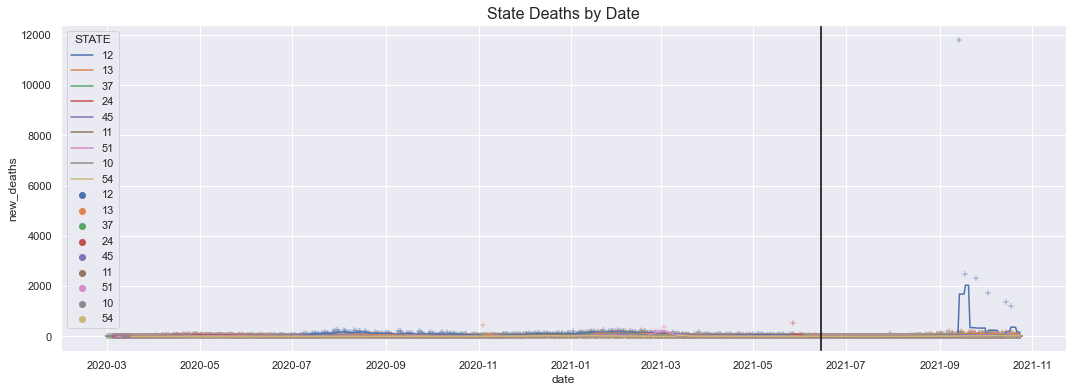

In [10]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='new_deaths', hue='STATE', data=state_df, marker='+');
sns.lineplot(x='date', y='smoothed_new_deaths',hue='STATE', data=state_df);
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='black')
plt.title('State Deaths by Date', fontsize=16);
plt.show()

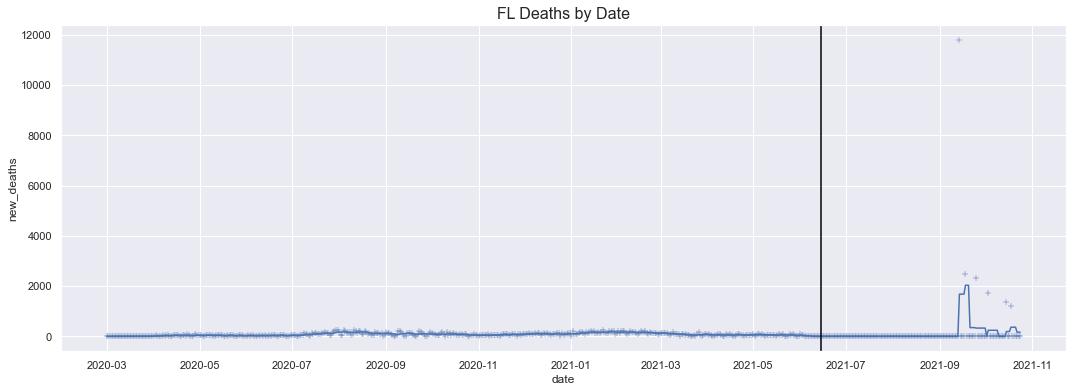

In [11]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='new_deaths', data=state_df[state_df['STATE'] == '12'], marker='+');
sns.lineplot(x='date', y='smoothed_new_deaths', data=state_df[state_df['STATE'] == '12']);
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='black')
plt.title('FL Deaths by Date', fontsize=16);
plt.show()

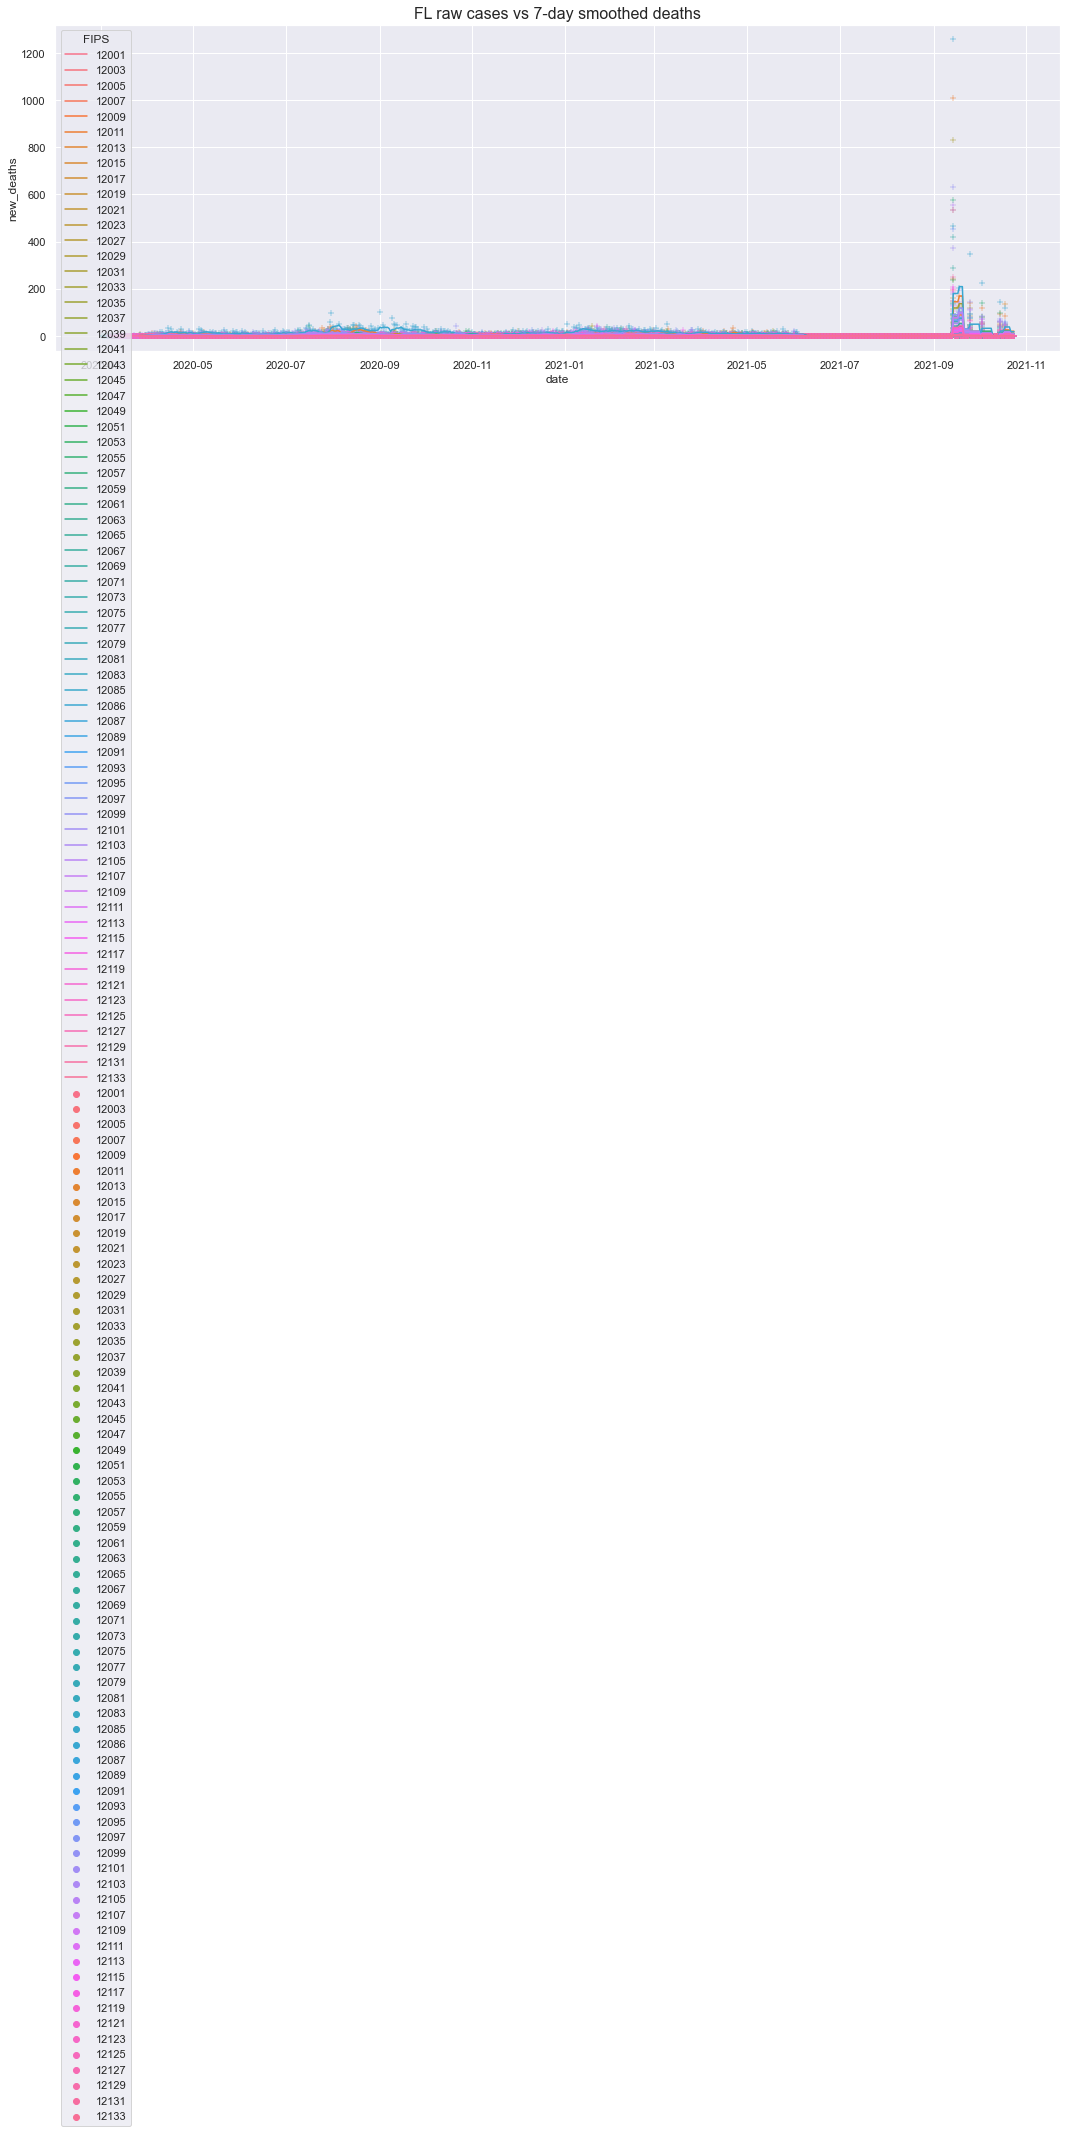

In [12]:
cd_only_fl = cd_df[(cd_df['FIPS'].apply(lambda x: x[:2] == '12'))]
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='new_deaths', data=cd_only_fl, hue='FIPS', marker='+');
sns.lineplot(x='date', y='smoothed_new_deaths', data=cd_only_fl, hue='FIPS');
plt.title('FL raw cases vs 7-day smoothed deaths', fontsize=16);
plt.show()


In [13]:
cd_only_fl[cd_only_fl['new_deaths'] > 1000]

,FIPS,date,state,cases,deaths,previous_day_cases,new_cases,smoothed_new_cases,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,previous_day_deaths,new_deaths,smoothed_new_deaths,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
5855,12011,2021-09-14,Florida,336741,4090.0,336741.0,0.0,1008.428571,1263.571429,1263.571429,1263.571429,3079.0,1011.0,144.428571,0.0,0.0,0.0
27369,12086,2021-09-14,Florida,642199,7730.0,642199.0,0.0,1374.285714,1725.714286,1725.714286,1725.714286,6472.0,1258.0,179.714286,0.0,0.0,0.0


In [14]:
date_mask = (cd_only_fl['date'] > '2021-09-01') & (cd_only_fl['date'] < '2021-09-25')
cd_only_fl[date_mask & (cd_only_fl['FIPS'] == '12011')][['FIPS','date', 'deaths', 'previous_day_deaths', 'new_deaths', 'smoothed_new_deaths']].head(20)

,FIPS,date,deaths,previous_day_deaths,new_deaths,smoothed_new_deaths
5843,12011,2021-09-02,3079.0,3079.0,0.0,0.000000
5844,12011,2021-09-03,3079.0,3079.0,0.0,0.000000
5845,12011,2021-09-04,3079.0,3079.0,0.0,0.000000
5846,12011,2021-09-05,3079.0,3079.0,0.0,0.000000
5847,12011,2021-09-06,3079.0,3079.0,0.0,0.000000
5848,12011,2021-09-07,3079.0,3079.0,0.0,0.000000
5849,12011,2021-09-08,3079.0,3079.0,0.0,0.000000
5850,12011,2021-09-09,3079.0,3079.0,0.0,0.000000
5851,12011,2021-09-10,3079.0,3079.0,0.0,0.000000
5852,12011,2021-09-11,3079.0,3079.0,0.0,0.000000


## Raw data

In [15]:
raw_df = pd.read_csv('../ny-times-git-repo/us-counties.csv', dtype={'fips':str})
raw_df['date'] = raw_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [16]:
raw_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


In [17]:
raw_df.dtypes

date      datetime64[ns]
county            object
state             object
fips              object
cases              int64
deaths           float64
dtype: object

In [18]:
raw_df[raw_df['fips'].isna()].groupby(['state']).sum()

,cases,deaths
state,,
Alaska,132263,62.0
American Samoa,83,0.0
Arizona,77,108.0
Arkansas,1625338,6.0
California,226979,4.0
Colorado,6823,35.0
Connecticut,482698,1759.0
Delaware,126895,15.0
Florida,3881744,378106.0


In [19]:
na_df = raw_df[raw_df['fips'].isna()]
fl_na_df = na_df[na_df['state'] == 'Florida']

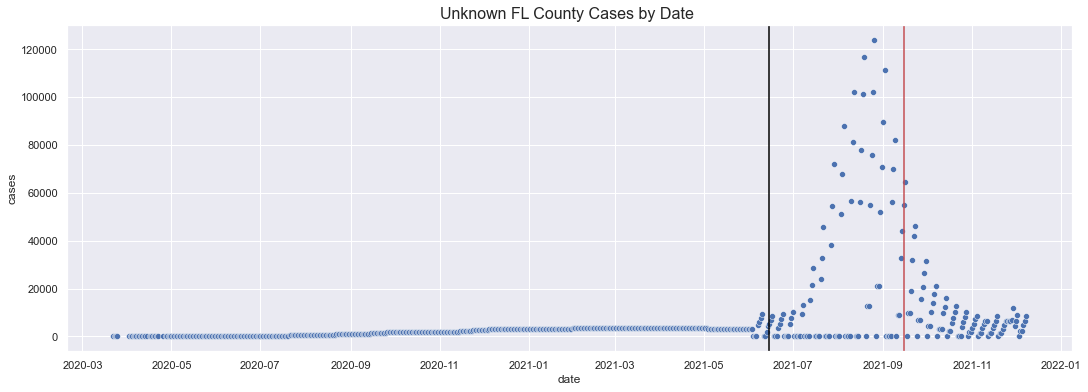

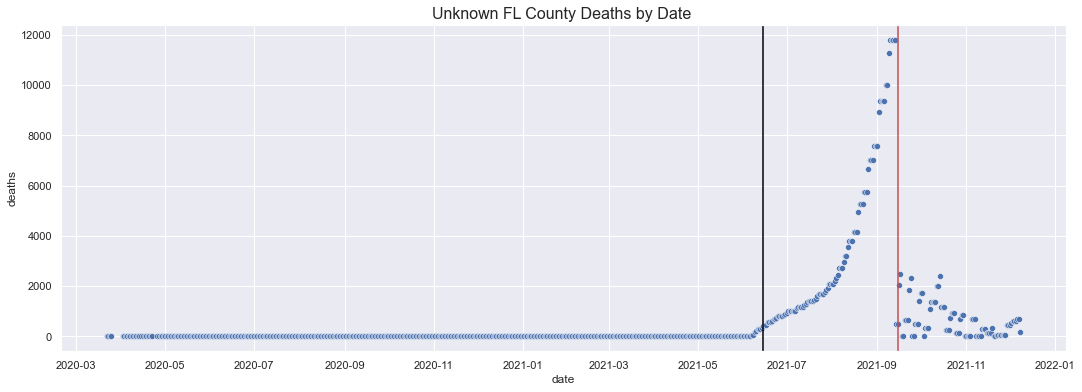

In [20]:
# Unknown FL county cases
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='cases', color='b', data=fl_na_df);
plt.title('Unknown FL County Cases by Date ', fontsize=16);
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='black')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='r')
plt.show()
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='deaths', color='b', data=fl_na_df);
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='black')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='r')
plt.title('Unknown FL County Deaths by Date ', fontsize=16);
plt.show()

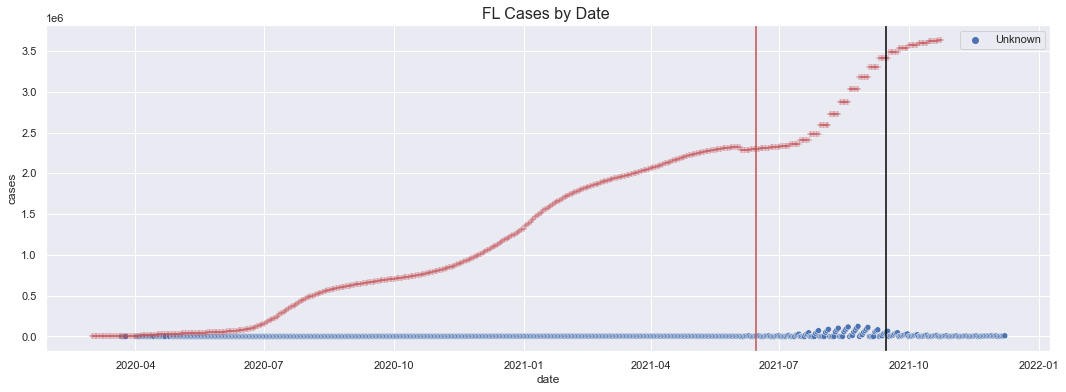

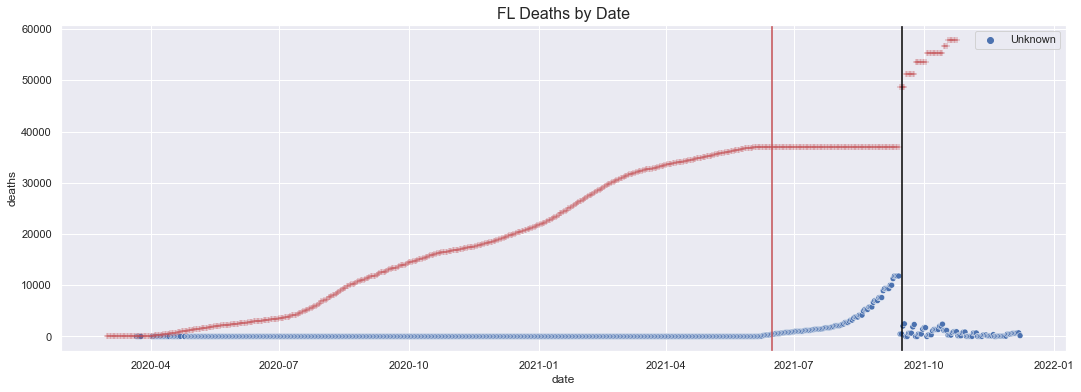

In [21]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='cases', hue='county', data=fl_na_df);
sns.scatterplot(x='date', y='cases', data=state_df[state_df['STATE'] == '12'], marker='+', color='r');
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='r')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='black')
plt.title('FL Cases by Date ', fontsize=16);
plt.show()
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='deaths', hue='county', data=fl_na_df);
sns.scatterplot(x='date', y='deaths', data=state_df[state_df['STATE'] == '12'], marker='+', color='r');
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='r')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='black')
plt.title('FL Deaths by Date', fontsize=16);
plt.show()

In [22]:
fl_df = state_df[state_df['STATE'] == '12']
fl_projections = fl_df.merge(fl_na_df, on='date', how='left', suffixes=('_known', '_unknown'))
fl_projections.head()

,date,STATE,cases_known,deaths_known,previous_day_cases,new_cases,smoothed_new_cases,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,...,new_deaths,smoothed_new_deaths,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths,county,state,fips,cases_unknown,deaths_unknown
0,2020-03-01,12,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,12,2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,12,3,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,12,3,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,12,4,0.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [23]:
fl_projections['combined_cases'] = fl_projections['cases_known'] + fl_projections['cases_unknown'].fillna(0)
fl_projections['combined_deaths'] = fl_projections['deaths_known'] + fl_projections['deaths_unknown'].fillna(0)

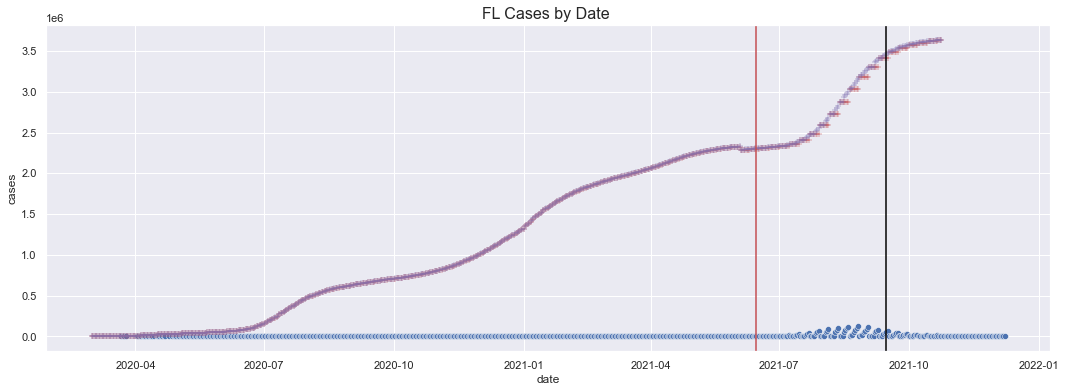

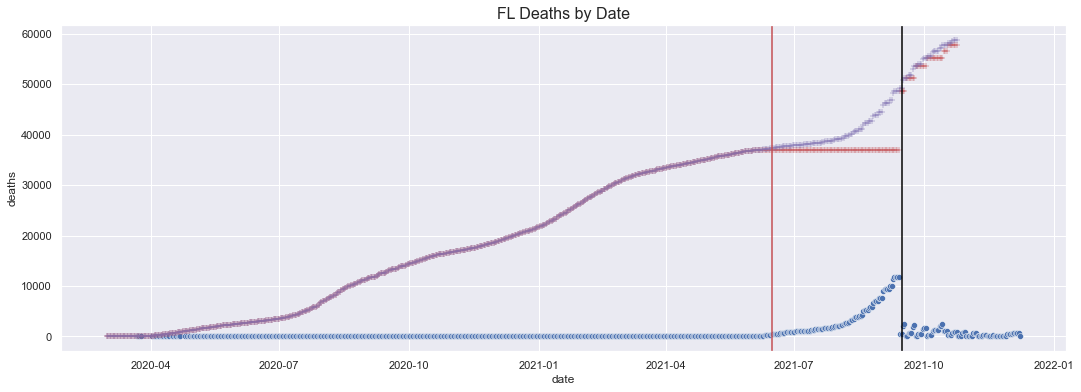

In [24]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='cases',data=fl_na_df);
sns.scatterplot(x='date', y='cases', data=state_df[state_df['STATE'] == '12'], marker='+', color='r');
sns.scatterplot(x='date', y='combined_cases', data=fl_projections, marker='+', color='m');
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='r')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='black')
plt.title('FL Cases by Date ', fontsize=16);
plt.show()
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='deaths',data=fl_na_df);
sns.scatterplot(x='date', y='deaths', data=state_df[state_df['STATE'] == '12'], marker='+', color='r');
sns.scatterplot(x='date', y='combined_deaths', data=fl_projections, marker='+', color='m');
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='r')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='black')
plt.title('FL Deaths by Date', fontsize=16);
plt.show()

## Creating weighted dist of unknown county deaths

In [71]:
cases_deaths_df = Reader.CasesAndDeathsReader().read_raw_data()
# Rename 'fips' for consistency
cases_deaths_df = cases_deaths_df.rename(columns={'fips':'FIPS'})

# Formatting dates
cases_deaths_df['date'] = cases_deaths_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

# Create state_code df
state_codes = pd.DataFrame({
    'fips_code' : ['10', '11', '12', '13', '24', '37', '45', '51', '54']
    , 'state_name' : ['Delware', 'DC', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
})

# Create df of NA FIPS codes
unk_cd_df = cases_deaths_df[cases_deaths_df['FIPS'].isna()].merge(state_codes, left_on='state', right_on='state_name')

# Filter to desired state FIPS codes
unk_cd_df = unk_cd_df[unk_cd_df['fips_code'].astype('int32').isin(state_filter)]

# Create a single df for the cases/deaths for each state that have an unknown county on a given date 
unk_cd_df = unk_cd_df[['date','fips_code', 'cases', 'deaths']].groupby(['date', 'fips_code']).sum().reset_index()

# Filter out NA FIPS codes
cases_deaths_df = cases_deaths_df[cases_deaths_df['FIPS'].notna()].copy()

# Create FIPS state codes
cases_deaths_df['FIPS_State'] = cases_deaths_df['FIPS'].apply(lambda x: x[:2])
# Filter to specific State FIPS Codes
cases_deaths_df = cases_deaths_df[cases_deaths_df['FIPS_State'].astype('int32').isin(state_filter)]

# Distribute unknown cases and death amongst each county

# Create county weight: Chose to use data as of 2021-10-01 for distribution
datemask = cases_deaths_df['date'] == '2021-10-01'

county_df = cases_deaths_df[datemask][['FIPS', 'FIPS_State', 'cases', 'deaths']].groupby(['FIPS', 'FIPS_State']).sum().reset_index()
state_df = cases_deaths_df[datemask][['FIPS', 'FIPS_State', 'cases', 'deaths']].groupby(['FIPS_State']).sum().reset_index()


county_weights = county_df.merge(state_df, left_on='FIPS_State', right_on='FIPS_State', how='left', suffixes=('_county', '_state'))
county_weights['cases_weighting'] = county_weights['cases_county'] / county_weights['cases_state']
county_weights['deaths_weighting'] = county_weights['deaths_county'] / county_weights['deaths_state']

cases_deaths_df = cases_deaths_df.merge(
    county_weights[['FIPS', 'cases_weighting', 'deaths_weighting']]
    , left_on=['FIPS']
    , right_on=['FIPS']
    , how='left')

cases_deaths_df['cases_weighting'] = cases_deaths_df['cases_weighting'].fillna(0)
cases_deaths_df['deaths_weighting'] = cases_deaths_df['deaths_weighting'].fillna(0)


cases_deaths_df = cases_deaths_df.merge(
    unk_cd_df
    , left_on=['date','FIPS_State']
    , right_on=['date','fips_code']
    , how='left'
    , suffixes=('','_unknown'))
cases_deaths_df['cases_unknown'] = cases_deaths_df['cases_unknown'].fillna(0)
cases_deaths_df['deaths_unknown'] = cases_deaths_df['deaths_unknown'].fillna(0)
cases_deaths_df['cases_from_unknown'] = (cases_deaths_df['cases_weighting'] * cases_deaths_df['cases_unknown'])
cases_deaths_df['deaths_from_unknown'] = (cases_deaths_df['deaths_weighting'] * cases_deaths_df['deaths_unknown'])
cases_deaths_df['cases_incl_unk'] = cases_deaths_df['cases'] + cases_deaths_df['cases_from_unknown']
cases_deaths_df['deaths_incl_unk'] = cases_deaths_df['deaths'] + cases_deaths_df['deaths_from_unknown']

# # Drop State codes
# # cases_deaths_df = cases_deaths_df.drop(['FIPS_State'], axis=1)



In [72]:
cases_deaths_df.head()

,date,state,FIPS,cases,deaths,FIPS_State,cases_weighting,deaths_weighting,fips_code,cases_unknown,deaths_unknown,cases_from_unknown,deaths_from_unknown,cases_incl_unk,deaths_incl_unk
0,2020-03-01,Florida,12057,1,0.0,12,0.065901,0.048918,NaN,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-03-01,Florida,12081,1,0.0,12,0.017765,0.016499,NaN,0.0,0.0,0.0,0.0,1.0,0.0
2,2020-03-02,Florida,12057,1,0.0,12,0.065901,0.048918,NaN,0.0,0.0,0.0,0.0,1.0,0.0
3,2020-03-02,Florida,12081,1,0.0,12,0.017765,0.016499,NaN,0.0,0.0,0.0,0.0,1.0,0.0
4,2020-03-02,Georgia,13121,2,0.0,13,0.083221,0.064617,NaN,0.0,0.0,0.0,0.0,2.0,0.0


In [73]:
cases_deaths_df.groupby(['date', 'FIPS_State'])['cases_from_unknown', 'deaths_from_unknown'].sum().reset_index().tail(10)

<ipython-input-73-f674342b6c8b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cases_deaths_df.groupby(['date', 'FIPS_State'])['cases_from_unknown', 'deaths_from_unknown'].sum().reset_index().tail(10)


,date,FIPS_State,cases_from_unknown,deaths_from_unknown
5367,2021-10-23,54,0.0,0.0
5368,2021-10-24,10,0.0,0.0
5369,2021-10-24,11,0.0,0.0
5370,2021-10-24,12,1.0,929.0
5371,2021-10-24,13,4690.0,9.0
5372,2021-10-24,24,0.0,65.0
5373,2021-10-24,37,0.0,0.0
5374,2021-10-24,45,0.0,0.0
5375,2021-10-24,51,0.0,0.0
5376,2021-10-24,54,0.0,0.0


In [74]:
unk_cd_df.tail(10)

,date,fips_code,cases,deaths
1745,2021-10-21,24,0,63.0
1746,2021-10-22,12,1,929.0
1747,2021-10-22,13,4690,9.0
1748,2021-10-22,24,0,63.0
1749,2021-10-23,12,1,929.0
1750,2021-10-23,13,4690,9.0
1751,2021-10-23,24,0,61.0
1752,2021-10-24,12,1,929.0
1753,2021-10-24,13,4690,9.0
1754,2021-10-24,24,0,65.0


In [75]:
cases_deaths_df.tail()

,date,state,FIPS,cases,deaths,FIPS_State,cases_weighting,deaths_weighting,fips_code,cases_unknown,deaths_unknown,cases_from_unknown,deaths_from_unknown,cases_incl_unk,deaths_incl_unk
339772,2021-10-24,West Virginia,54101,1134,17.0,54,0.004031,0.003761,NaN,0.0,0.0,0.0,0.0,1134.0,17.0
339773,2021-10-24,West Virginia,54103,2532,50.0,54,0.009508,0.012359,NaN,0.0,0.0,0.0,0.0,2532.0,50.0
339774,2021-10-24,West Virginia,54105,835,13.0,54,0.003069,0.002687,NaN,0.0,0.0,0.0,0.0,835.0,13.0
339775,2021-10-24,West Virginia,54107,12961,240.0,54,0.048839,0.056153,NaN,0.0,0.0,0.0,0.0,12961.0,240.0
339776,2021-10-24,West Virginia,54109,3600,59.0,54,0.013527,0.013702,NaN,0.0,0.0,0.0,0.0,3600.0,59.0


In [76]:
cases_deaths_df[cases_deaths_df['FIPS_State'] == '12'].tail()

,date,state,FIPS,cases,deaths,FIPS_State,cases_weighting,deaths_weighting,fips_code,cases_unknown,deaths_unknown,cases_from_unknown,deaths_from_unknown,cases_incl_unk,deaths_incl_unk
339255,2021-10-24,Florida,12125,3057,96.0,12,0.000849,0.001456,12,1.0,929.0,0.000849,1.352408,3057.000849,97.352408
339256,2021-10-24,Florida,12127,75256,1271.0,12,0.020552,0.021594,12,1.0,929.0,0.020552,20.060713,75256.020552,1291.060713
339257,2021-10-24,Florida,12129,6375,103.0,12,0.001761,0.001754,12,1.0,929.0,0.001761,1.629825,6375.001761,104.629825
339258,2021-10-24,Florida,12131,11895,159.0,12,0.003269,0.002725,12,1.0,929.0,0.003269,2.531430,11895.003269,161.531430
339259,2021-10-24,Florida,12133,4542,62.0,12,0.001255,0.001157,12,1.0,929.0,0.001255,1.074991,4542.001255,63.074991


In [77]:
test_fl_df = cases_deaths_df[cases_deaths_df['FIPS_State'] == '12'] \
    [['date', 'cases', 'deaths', 'cases_incl_unk', 'deaths_incl_unk']] \
    .groupby(['date']).sum().reset_index()

In [78]:
test_fl_unk = cases_deaths_df

In [79]:
test_fl_df.head()

,date,cases,deaths,cases_incl_unk,deaths_incl_unk
0,2020-03-01,2,0.0,2.0,0.0
1,2020-03-02,2,0.0,2.0,0.0
2,2020-03-03,3,0.0,3.0,0.0
3,2020-03-04,3,0.0,3.0,0.0
4,2020-03-05,4,0.0,4.0,0.0


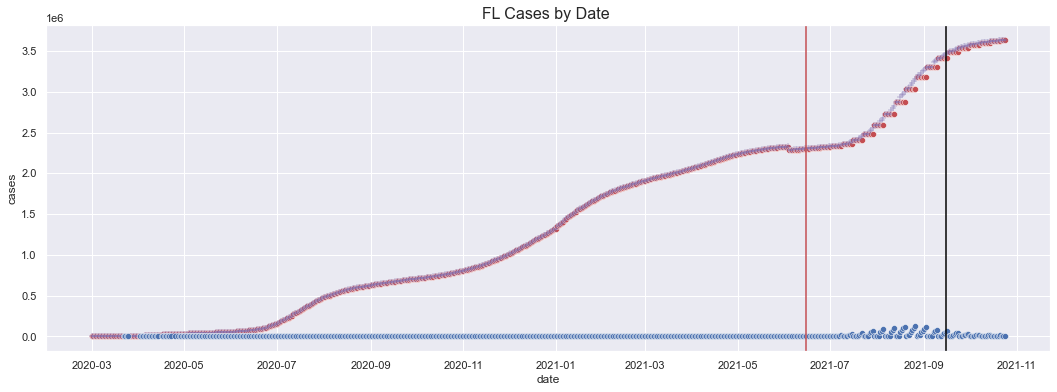

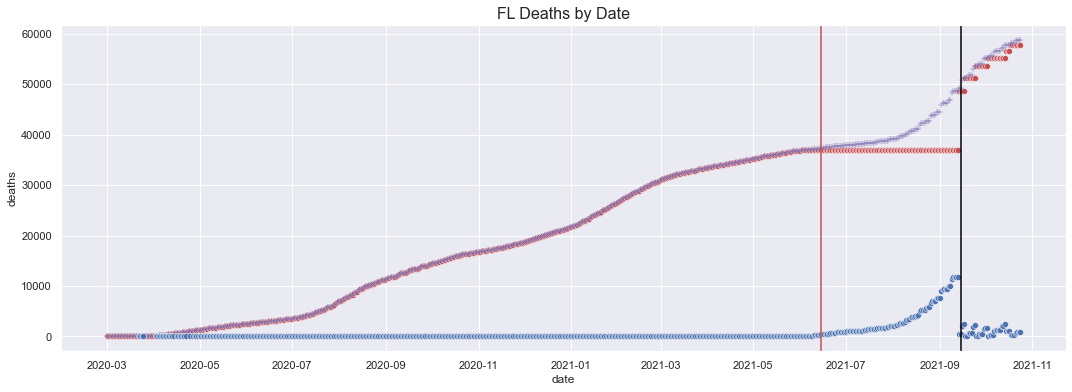

In [80]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='cases', data=test_fl_df, color='r');
sns.scatterplot(x='date', y='cases_incl_unk', data=test_fl_df, marker='+', color='m');
sns.scatterplot(x='date', y='cases', data=unk_cd_df[unk_cd_df['fips_code'] == '12'], marker='o', color='b');
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='r')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='black')
plt.title('FL Cases by Date ', fontsize=16);
plt.show()
plt.figure(figsize=(18, 6))
sns.scatterplot(x='date', y='deaths', data=test_fl_df, color='r');
sns.scatterplot(x='date', y='deaths_incl_unk', data=test_fl_df, marker='+', color='m');
sns.scatterplot(x='date', y='deaths', data=unk_cd_df[unk_cd_df['fips_code'] == '12'], marker='o', color='b');
plt.axvline(x=datetime.strptime('2021-06-15', '%Y-%m-%d'), color='r')
plt.axvline(x=datetime.strptime('2021-09-15', '%Y-%m-%d'), color='black')
plt.title('FL Deaths by Date', fontsize=16);
plt.show()

In [ ]:
unk_cd_df.head()

In [ ]:
cases_deaths_df.head()

In [ ]:
# Distribute unknown cases and death amongst each county

# Create county weight: Choose to use data as of 2021-10-01 for distribution
weighting_df = cases_deaths_df.copy()
datemask = weighting_df['date'] == '2021-10-01'
state_cases = weighting_df[datemask].groupby(['FIPS_State'])['cases'].sum().reset_index()
county_cases = weighting_df[datemask].groupby(['FIPS', 'FIPS_State'])['cases'].sum().reset_index()

In [ ]:
state_cases.head()

In [ ]:
county_cases

In [ ]:
county_weights = county_cases.merge(state_cases, left_on='FIPS_State', right_on='FIPS_State', how='left', suffixes=('_county', '_state'))
county_weights['cases_weighting'] = county_weights['cases_county'] / county_weights['cases_state']
county_weights.head()

In [ ]:
cases_deaths_df = cases_deaths_df.merge(county_weights[['FIPS', 'cases_weighting']], left_on=['FIPS'], right_on=['FIPS'])

In [ ]:
cases_deaths_df.head()

In [ ]:
cases_deaths_df = cases_deaths_df.merge(
    unk_cd_df
    , left_on=['date','FIPS_State']
    , right_on=['date','fips_code']
    ,how='left'
    , suffixes=('','_unknown'))

cases_deaths_df['cases_incl_unk'] = cases_deaths_df['cases'] + (cases_deaths_df['cases_weighting'] * cases_deaths_df['cases_unknown'])

In [ ]:
cases_deaths_df.head()

In [ ]:
cases_deaths_df[(cases_deaths_df['state'] == 'Florida') & (cases_deaths_df['date'] == '2020-03-01')].head(50)

In [81]:
df = Reader.CasesAndDeathsReader().read_and_process_data(state_filter)

In [82]:
df.head()

,FIPS,date,state,cases,deaths,previous_day_cases,new_cases,smoothed_new_cases,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,previous_day_deaths,new_deaths,smoothed_new_deaths,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
0,10001,2020-03-18,Delaware,3,0.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,10001,2020-03-19,Delaware,4,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001,2020-03-20,Delaware,4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10001,2020-03-21,Delaware,5,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10001,2020-03-22,Delaware,5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
